In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing  import FunctionTransformer
np.set_printoptions(precision=3, suppress=True)
import warnings
warnings.filterwarnings("ignore")

### Standardization

For a lot of data sets, it is a good idea to standardize your features. This means to rescale  each feuture so it has properties of standard normal distribution. For that we find the means $\mu^{(i)}$ and standard deviations $\sigma^{(i)}$ of each features in your train set and then create a normalized values: $$ \hat{x}^{(i)}=\frac{x^{(i)}-\mu^{(i)}}{\sigma^{(i)}}.$$

Your test data has to be standardized as well. However, you need to use means and standard deviations from train data instead.

Lets consider a breast cancer data set from `sklearn` and apply standartization to it:

In [94]:
dataset=datasets.fetch_openml("titanic", version=1)
X,y= dataset.data, dataset.target
X.shape

(1309, 13)

In [95]:
print(dataset['DESCR'])

**Author**: Frank E. Harrell Jr., Thomas Cason  
**Source**: [Vanderbilt Biostatistics](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html)  
**Please cite**:   

The original Titanic dataset, describing the survival status of individual passengers on the Titanic. The titanic data does not contain information from the crew, but it does contain actual ages of half of the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. The datasets used here were begun by a variety of researchers. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

Thomas Cason of UVa has greatly updated and improved the titanic data frame using the Encyclopedia Titanica and created the dataset here. Some duplicate passengers have been dropped, many errors corrected, many missing ages filled in, and new variable

In [96]:
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [97]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: category
Categories (2, object): ['0', '1']

In [98]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB


As you can see we have different types of data. Moreover, we can see some data is missing.

In [99]:
X.isna().sum()

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Let's look at numerical data first and their relation. If we want to understand relationships between different data types, we need to transform the data somehow. We also need to deal with missing data. So, let's focus on "age" and "fare"  columns.

First let's deal with missing data. There are many ways of doing it. An easy solution would be to delete all entries with missing data, but sometimes this is not a good solution as we might lose too much. Another way is to delete columns with too mucg missing data. It might lead to the same problem too. Third way is to use imputer: we replace missing data based on other data in the same column. We can use means, medians, or other measures. Here I will use medians. As with other models, `fit` calculates needed changes, `transform` applies the changes and `fit_transform` does both at the same time.

In [100]:
X_num=X.loc[:,["fare", "age"]]
imp_median = SimpleImputer(strategy='median')
X_num.iloc[:,:]=imp_median.fit_transform(X_num.iloc[:,:])
X_num.isna().sum()

fare    0
age     0
dtype: int64

We can use `mean` instead of median for real type data.

The numerical data has another problem. The values are too different. Fare can reach over values over 200, but age can't. So, we can compare them fairly. To fix that we can use scaling. Two common ways to scale the data are normalization and standartization.

In stardatization, we assume normal distribution and we standartize to standard normal distribution by applying $$z^{(i)}=\frac{x^{(i)}-\mu}{\sigma}$$ to the whole data. 

In Python to do this, normally we create Standard Scaler and use it on our training set to find means and standard deviation of each column (`fit`) and then standardize it (`transform`). Then use the same parameters (mean and std. deviation from training set) and standardize the test set (so only `transform`).

So let's standartize our same two columns.

In [118]:
sc=StandardScaler()

X_num.iloc[:,:]=sc.fit_transform(X_num.iloc[:,:])
X_num

,fare,age
0,5.577573,-0.019608
1,3.763022,-2.241983
2,3.763022,-2.156256
3,3.763022,0.059527
4,3.763022,-0.336149
...,...,...
1304,-0.397836,-1.167067
1305,-0.397836,-0.098743
1306,-0.617243,-0.217446
1307,-0.617243,-0.177879


There are other scaling procedures. Another common one is normalization. For that we find maximum and minimum of each feature and normalize as follows:
$$ \hat{x}^{(i)}=\frac{x^{(i)}-\min^{(i)}}{\max^{(i)}-\min^{(i)}}.$$

### Outliers

Sometimes we would like to see if we have outliers and/or remove outliers. There are a few ways of doing it. We can look at the boxplot that can show us our outliers. Here how to understand the box plot:
1. Middle line inside the box is median
2. The bottom and top line of the box is First and Third Quartile, and the distance berween these two quartiles is called IQR
3. Each whisker has size equal to 1.5*IQR.
4. Anything outside the whiskers is considered to be outlier.

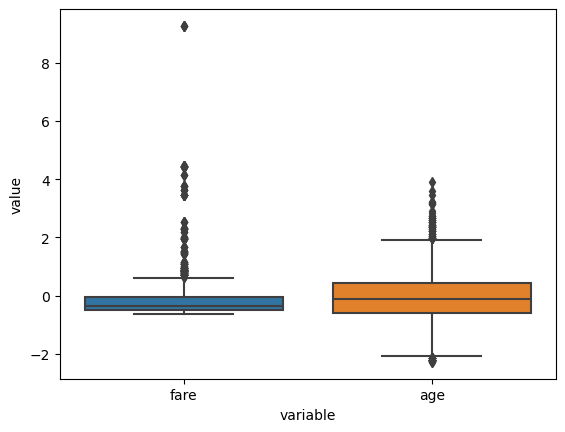

In [102]:
sns.boxplot(x="variable", y="value", data=pd.melt(X_num))

plt.show()

Another way to see outliers is to use z-score. Generally, if the absolute value of z-score is higher than 3 or 3.5, the data point is considered to be an outlier.

In [103]:
Outliers=X_num[(~X_num['fare'].between(-3.5,3.5)) | (~X_num['age'].between(-3.5,3.5))]
Outliers

,fare,age
10,3.755557,1.356309
11,3.755557,-0.891698
14,-0.063437,3.914386
16,4.142160,-0.426593
17,4.142160,1.588862
23,3.755557,0.968722
24,3.644466,-0.039005
35,4.429355,1.201274
49,9.262028,0.503617
50,9.262028,2.209001


Let's remove these points from X_num:"

In [130]:
X_num=X_num[(X_num['fare'].between(-3.5,3.5)) & (X_num['age'].between(-3.5,3.5))]
X_num

,fare,age
5,-0.030729,1.483958
6,1.529513,2.670985
7,-0.836521,0.771743
8,0.725873,1.879634
9,0.665931,3.304066
...,...,...
1304,-0.397836,-1.167067
1305,-0.397836,-0.098743
1306,-0.617243,-0.217446
1307,-0.617243,-0.177879


Other methods of detecting outliers are:

1. Isolation forest, which is based on Random Forest Model and is a good way of doing it if your dataset is huge and have many features.

2. DBScan, analysis clustering of your data to find outliers.

What to do with outliers?
Sometimes removing them is ok. Sometimes, replacing them with some values (mean, median, $Q1-1.5*IQR$, $Q3+1.5*IQR$). Usually it depends on dataset and why we have outliers there.

### Categorical data

What about categorical data? 
If the data is binary, we can always use "0" and "1". If we have 3 categories, we can try using "0", "1" and "2", but that may lead to problems. This can mean that category "1" is between categories "0" and "2", but in reality there shouldn't be order to our categories. One solution to this is "One Hot Encoding". Here we create an array for each data point full of zeros and a single "1" that represents category. In other words, instead of "0", "1" and "2", we have "[1,0,0]", "[0,1,0]" and "[0,0,1]".

In [105]:
X_cat=X.loc[:,["embarked", "sex"]]

onehotenc=OneHotEncoder(sparse_output=False,handle_unknown='ignore')

X_cat_emb=onehotenc.fit_transform(X_cat.loc[:,["embarked"]])
one_hot_df = pd.DataFrame(X_cat_emb, columns=onehotenc.get_feature_names_out(["embarked"]))

df_encoded = pd.concat([X_cat, one_hot_df], axis=1)

df_encoded = df_encoded.drop(["embarked"], axis=1)
df_encoded 

,sex,embarked_C,embarked_Q,embarked_S,embarked_nan
0,female,0.0,0.0,1.0,0.0
1,male,0.0,0.0,1.0,0.0
2,female,0.0,0.0,1.0,0.0
3,male,0.0,0.0,1.0,0.0
4,female,0.0,0.0,1.0,0.0
...,...,...,...,...,...
1304,female,1.0,0.0,0.0,0.0
1305,female,1.0,0.0,0.0,0.0
1306,male,1.0,0.0,0.0,0.0
1307,male,1.0,0.0,0.0,0.0


For binary in `sex` column, lets replace it with 0 and 1:

In [106]:
df_encoded['sex']=df_encoded.sex.map({'male':0,'female':1})
df_encoded 

,sex,embarked_C,embarked_Q,embarked_S,embarked_nan
0,1,0.0,0.0,1.0,0.0
1,0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,1.0,0.0
3,0,0.0,0.0,1.0,0.0
4,1,0.0,0.0,1.0,0.0
...,...,...,...,...,...
1304,1,1.0,0.0,0.0,0.0
1305,1,1.0,0.0,0.0,0.0
1306,0,1.0,0.0,0.0,0.0
1307,0,1.0,0.0,0.0,0.0


As you can see, we just went from two features to 5. This is not good, so we would like to reduce it back. We can do this by selecting certain amount of columns that affect our target in the best way according to some statistics.

In [107]:
df_encoded2=SelectPercentile(chi2, percentile=70).fit_transform(df_encoded, y)
df_encoded2

array([[1., 0., 1.],
       [0., 0., 1.],
       [1., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

As a bonus, it dealt with a couple of missing values for us as well.

### Pipeline

As you can see there is many different things we can do based on type of data. Cutting the data like this and dealing with everything separatly can be quite messy. To organize it better, we can use `pipeline`

In [131]:
X=X.loc[:,[ "fare", "age","pclass", "embarked", "sex"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [132]:
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=70)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [136]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [135]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))  # average accuracy
clf

model score: 0.790


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=70,
                                                                                    score_func=<function chi2 at 0x000002C351FF5DA0>))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

In [15]:
y_pred=clf.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[145,  17],
       [ 36,  64]], dtype=int64)

### Regularization

Regularization is a way to avoid (or at least minimize) overfitting. Recall that the more complex our model, the higher chances of overfitting, but it would lower our loss. So, we want to find a balance between loss and complexity. For that we need to find a way to measure complexity of our model, add this to our loss function, and minimaze the sum: $$\min_{param} \left[Loss(data, param) + \lambda \cdot Complexity(param)\right]$$

The hyperparameter $\lambda$ is a way for us to control how important regularization is.

Two common ways to do regularization is $L1-Regularization$ and $L2-Regularization$. Idea behind both is quite simple. The more complex model is, the more parameters it has. For the  $L1-Regularization$, we just add absolute values of our parameters and for $L2-Regularization$ we add squares of our parameters. The second case is just a square norm of a vector containing our parameters.

For example, for linear regression our loss was $$Loss  = \frac{1}{N}||w{\bf x}+b-{\bf y}||^2$$ So with $L1-Regularization$ we would want to minimize 
$$\frac{1}{N}||w{\bf x}+b-{\bf y}||^2+\lambda |w|$$

Let's try to apply $L1-Regularization$ to polynomial regression, where we would like a fit a polynomial curve to given data.

We will use two models. One is polynomial regression that we get directly with no training and calculate loss at the end with $L1-Regularization$. Second model uses `Lasso`, which uses $L1-Regularization$ by default to get the curve needed.

In [64]:
n_samples=40
Lambda=0.001

X = np.random.rand(n_samples)
y=np.cos(1.5 * np.pi * X)+0.5*np.random.rand(n_samples)
X=X.reshape(-1,1)

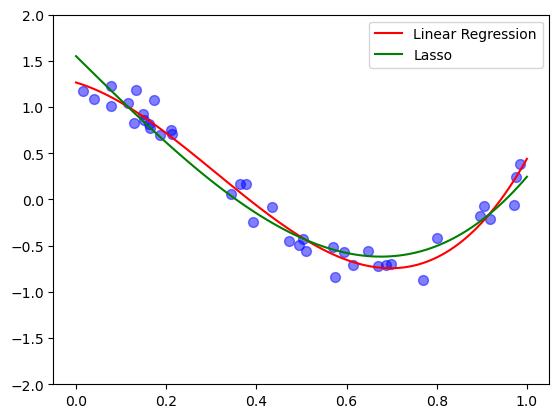

In [65]:
polymodel = PolynomialFeatures(degree=3, include_bias=True)
data=polymodel.fit_transform(X)
model1=LinearRegression()
model2=Lasso(alpha=Lambda)


model1.fit(data,y) 
model2.fit(data,y) 


X_plot=np.linspace(0,1,100).reshape(-1,1)
X_plot_poly=polymodel.transform(X_plot)
fig=plt.figure()
plt.scatter(X,y, c='b', s=50, alpha=.5)
plt.plot(X_plot,model1.predict(X_plot_poly),'-r', label='Linear Regression')
plt.plot(X_plot,model2.predict(X_plot_poly),'-g', label='Lasso')
plt.legend()
plt.ylim(-2,2)
fig.show()

In [66]:
y_pred1=model1.predict(polymodel.transform(X))
y_pred2=model2.predict(polymodel.transform(X))

Loss1=((y_pred1-y)**2).mean() +  Lambda*(np.abs(model1.coef_)).sum()
Loss2=((y_pred2-y)**2).mean() +  Lambda*(np.abs(model2.coef_)).sum()
Loss1,Loss2
print(f'Loss of Lin. Reg. Model with L1 Reg= {Loss1:.3f} \nLoss of Lasso Model with L1 Reg = {Loss2:.3f}')
print('Weights of Lin. Reg. Model=', model1.coef_[1:])
print('Weights of Lasso Model=', model2.coef_[1:])

Loss of Lin. Reg. Model with L1 Reg= 0.034 
Loss of Lasso Model with L1 Reg = 0.033
Weights of Lin. Reg. Model= [-1.447 -8.231  8.852]
Weights of Lasso Model= [-4.812 -0.     3.507]


Let's see what happens to loss in both of our models if we start increasing complexity:

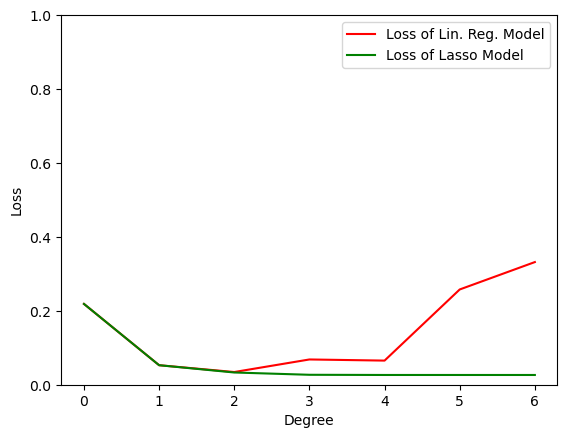

In [67]:
Loss1, Loss2= [],[]

for deg in range(1,8):
    polymodel = PolynomialFeatures(degree=deg, include_bias=True)
    data=polymodel.fit_transform(X)
    model1=LinearRegression()
    model2=Lasso(alpha=Lambda)
    
    
    model1.fit(data,y) 
    model2.fit(data,y) 
  
    y_pred1=model1.predict(polymodel.transform(X))
    y_pred2=model2.predict(polymodel.transform(X))
    
    Loss1.append(((y_pred1-y)**2).mean() +  Lambda*(np.abs(model1.coef_)).sum())
    Loss2.append(((y_pred2-y)**2).mean() +  Lambda*(np.abs(model2.coef_)).sum())

fig=plt.figure()
xv=np.arange(0,deg)
plt.plot(xv,Loss1,'-r', label='Loss of Lin. Reg. Model')
plt.plot(xv,Loss2,'-g', label='Loss of Lasso Model')
plt.ylim(0,1)
plt.ylabel("Loss")
plt.xlabel('Degree')
plt.legend()
plt.show()


As you can see, as we increase our complexity, the regularization term makes our loss go up. Since Lasso model tries to minimize both complexity and loss, it generally makes most of the weights be zero. 